# Gradient-Based Optimization

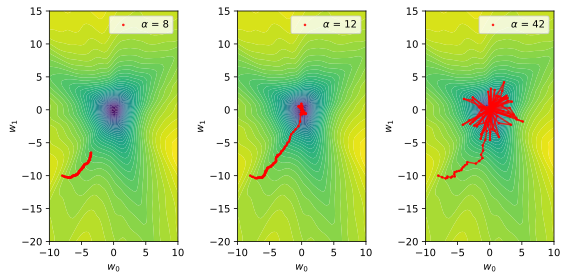

In [7]:
#| code-fold: true
#| echo: false
%config InlineBackend.figure_formats = ['svg'] 
import warnings
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
warnings.filterwarnings("ignore")


def plot_contourf(ax, f, title="", levels=20, x_min=-5, x_max=5, y_min=-5, y_max=5, N=50):
    x = np.linspace(x_min, x_max, N)
    y = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            Z[i, j] = f(X[i, j], Y[i, j])

    ax.contourf(X, Y, Z, levels=levels, cmap="viridis")
    ax.set_title(title)
    ax.set_xlabel(r"$w_0$")
    ax.set_ylabel(r"$w_1$")

def plot_trajectory(ax, w, color, s=8, alpha=1.0, **kw):
    ax.scatter(w[:, 0], w[:, 1], marker="o", s=s, color=color, alpha=alpha, **kw)
    for t in range(1, len(w)):
        ax.plot(*zip(w[t - 1], w[t]), color=color, alpha=alpha)


def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(w0, w1, X, y):
    """non-convex loss: MSE between squared sigmoid outputs and targets"""
    w = np.array([w0, w1])
    p = sigmoid(X @ w) ** 2
    return ((p - y) ** 2).mean()

def grad(w, X, y):
    z = X @ w
    s = sigmoid(z)
    p = s ** 2
    delta = (p - y) * 2 * s * (1 - s) * 2  # chain rule
    g = (delta.reshape(-1, 1) * X).mean(axis=0)
    return g


def sgd(w0, X, y, eta=0.1, steps=10, B=32):
    w = np.zeros([steps, 2])
    w[0, :] = w0
    for j in range(1, steps):
        batch = np.random.randint(0, len(X), size=(B,))
        u = w[j - 1, :]
        w[j, :] = u - eta * grad(u, X[batch], y[batch])
    return w
    

# Generate data
np.random.seed(1)
n = 1000
X = np.random.randn(n, 2)
y = np.random.randint(0, 2, size=n)
w_init = [-8, -10]
w_step = lambda lr: sgd(w_init, X, y, eta=lr, steps=100, B=len(X))

# Plot
fig, ax = plt.subplots(1, 3, figsize=(8, 4), layout="constrained")
LRs = [8, 12, 42]
colors = ["red"] * len(LRs) # ["black", "orange", "red"]
for i in range(len(LRs)):
    plot_contourf(ax[i], partial(loss, X=X, y=y), title="", levels=50, x_min=-10, x_max=10, y_min=-20, y_max=15)
    plot_trajectory(ax[i], w_step(LRs[i]), color=colors[i], s=3, label=r"$\alpha$ = " + str(LRs[i]), alpha=0.8)
# plot_trajectory(ax, w_step(LRs[1]), color=colors[1], s=3, label=r"$\alpha$ = " + str(LRs[1]))
# plot_trajectory(ax, w_step(LRs[2]), color=colors[2], s=3, label=r"$\alpha$ = " + str(LRs[2]))
    ax[i].legend()

fig.tight_layout()

Typically, we take $B = 8, 32, 64, 128, 256.$ 

**Expectation.** For fixed ${\Theta},$ the estimated gradient is *unbiased* in the sense that

$$
\begin{aligned}
\mathbb{E}\left[\frac{1}{B} \sum_{j=1}^{B} \nabla \mathcal{L}_{\mathcal{B}, j}({\Theta})\right]
&= \frac{1}{B} \sum_{j=1}^{B} \mathbb{E}\left[\nabla \mathcal{L}_{\mathcal{B}, j}({\Theta})\right] \\
&\approx \frac{1}{B} \sum_{j=1}^{B} \left( \frac{1}{N} \sum_{i=1}^N \nabla \mathcal{L}_i({\Theta}) \right)
=
\nabla \mathcal{L}({\Theta}).
\end{aligned}
$$

The second equality holds because shuffling the dataset at the start of an epoch makes the $j$-th element of the mini-batch $\mathcal{B}$ be any element of the dataset with uniform probability. 

**Variance.** For the sake of tractability, let's assume that each mini-batch $\mathcal{B}$ is sampled with replacement, so that all samples are independent. This is an approximation of the SGD algorithm used in practice.
Then, the variance of the gradient with uncorrelated mini-batches decreases linearly with increasing batch size $B$:

$$
\mathbb{V}\left(\frac{1}{B} \sum_{j=1}^{B} \nabla \mathcal{L}_{\mathcal{B}, j}\left({\Theta}\right)\right)=\frac{1}{B} \,\mathbb{V}\Bigg(\nabla \mathcal{L}_{\mathcal{B}, 1}\left({\Theta}\right)\Bigg).
$$

**Example.** SGD ($B = 16$ and $B = 128$) vs GD with $N = 1000$ on a non-convex loss surface. Observe that the SGD steps with larger batch size is less noisy:

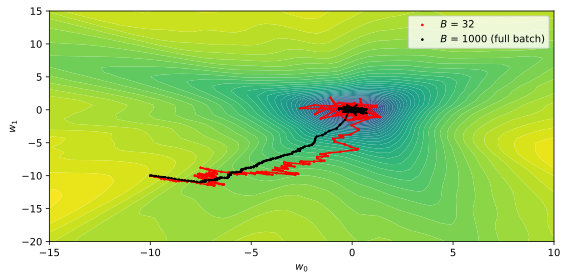

In [16]:
#| code-fold: true
#| echo: false
np.random.seed(42)
w_init = [-10, -10]
w_step = lambda B: sgd(w_init, X, y, eta=10.0, steps=200, B=B)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4), layout="constrained")
Bs = [32, 1000]
colors= ["red", "black"]
plot_contourf(ax, partial(loss, X=X, y=y), title="", levels=50, x_min=-15, x_max=10, y_min=-20, y_max=15)
plot_trajectory(ax, w_step(Bs[0]), color=colors[0], s=3, label=r"$B$ = " + str(Bs[0]))
plot_trajectory(ax, w_step(Bs[1]), color=colors[1], s=3, label=r"$B$ = " + str(Bs[1]) + " (full batch)")
ax.legend()
fig.tight_layout()

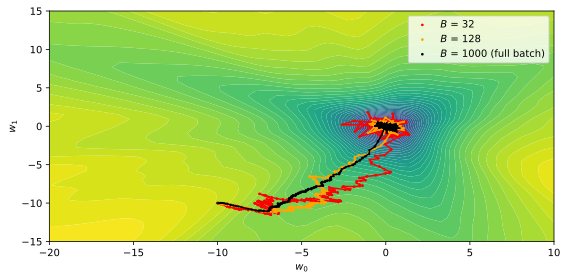

In [ ]:
#| code-fold: true
#| echo: false
np.random.seed(42)
w_init = [-10, -10]
w_step = lambda B: sgd(w_init, X, y, eta=10.0, steps=200, B=B)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4), layout="constrained")
Bs = [32, 128, 1000]
colors= ["red", "orange", "black"]
plot_contourf(ax, partial(loss, X=X, y=y), title="", levels=50, x_min=-15, x_max=10, y_min=-15, y_max=15)
plot_trajectory(ax, w_step(Bs[0]), color=colors[0], s=3, label=r"$B$ = " + str(Bs[0]))
plot_trajectory(ax, w_step(Bs[1]), color=colors[1], s=3, label=r"$B$ = " + str(Bs[1]))  
plot_trajectory(ax, w_step(Bs[2]), color=colors[2], s=3, label=r"$B$ = " + str(Bs[2]) + " (full batch)")
ax.legend()
fig.tight_layout()